In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import contextily as ctx
import geopandas as gpd
import plotly.graph_objects as go
import dash
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import plotly.io as pio
from IPython.display import HTML


def set_dataframe(df_city : pd.DataFrame) -> pd.DataFrame:
    df_city=df_city[df_city['accommodates']==2]
    df_city=df_city[(df_city['room_type']=='Private room')]
    df_city=df_city[df_city['minimum_nights']<3]
    df_city=df_city[df_city['amenities'].apply(lambda x: "Air conditioning" in x)]
    return df_city

def create_dataframe(df_city : pd.DataFrame) -> pd.DataFrame: 
    df_city.loc[:,'price'] = df_city.loc[:,'price'].str.strip('$').str.replace(',','').astype(float)
    df_city=df_city[df_city['price']<1000]
    df_city=set_dataframe(df_city)
    return df_city[['id','price','accommodates','neighbourhood_cleansed','neighbourhood_group_cleansed','room_type','amenities']]

def calc_n_perc(x, values):
    n = int(np.round(x/100 * np.sum(values)))
    return f'{n} {x:.1f}%'    

def getContainer(title):
    return dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1(title, className="text-center my-4"),
        ], width=12)
    ]),
    dbc.Row([
        dbc.Col([
            dbc.Label("Range Prezzo:", className="h5", style={'margin-right': '10px'}),
            rangeSlider()
        ], width=12, className="d-flex align-items-center mb-4"),
    ]),
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='map-graph', config={'displayModeBar': True})
        ], width=12)
    ])
    ], fluid=True)

def rangeSlider():
    return html.Div(dcc.RangeSlider(
        id='price-slider',
        min=10,
        max=999,
        step=1,
        tooltip={"placement": "bottom", "always_visible": True,"template": "$ {value}"},
        marks={10: {'label': '$10'}, 999: {'label': '$999'}},
        value=[min_price_df, max_price_df],
        className="p-2",
        ),style={'width': '100%'}
    )

def getBarColor(fig):
    return fig.add_trace(go.Scattermapbox(
        lon=df_florence['longitude'],
        lat=df_florence['latitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=0,
            color=df_florence['price'],
            colorscale='Spectral_r',
            colorbar=dict(
                orientation='v',
                x=0.0,
                y=0.5,
                xanchor='right',
                yanchor='middle',
                len=0.75,
                tickprefix='$'
            )
        ),
        hoverinfo='skip',
        showlegend=False,
    ))

def getLegend(fig, name):
    return fig.add_trace(go.Scattermapbox(
        lon=[None],
        lat=[None],
        mode='markers',
        marker=go.scattermapbox.Marker(
            color='black',
        ),
        name=name,
        legendgroup=name,
        showlegend=True
    ))

def getUpdate(fig):
    return fig.update_layout(
        mapbox=dict(
            style="carto-positron",
            zoom=11,
            center=dict(lat=df_florence['latitude'].mean(), lon=df_florence['longitude'].mean()),
        ),
        margin={"r": 0,"t": 0, "l": 0, "b": 0},
        legend=dict(
            title=dict(text='Quartieri'),
            yanchor="middle",
            y=0.5,
            x=1.0,
            xanchor="left",
        ),
    )
df_florence=pd.read_csv('Firenze/listings.csv')
df_florence=df_florence[['price','neighbourhood_cleansed','room_type','accommodates','latitude','longitude','minimum_nights','amenities']]
df_florence=df_florence.dropna(subset=['price'])
df_florence.loc[:,'price'] = df_florence.loc[:,'price'].str.strip('$').str.replace(',','').astype(float)
df_florence=df_florence[df_florence['price']<1000]
quartieri_df=gpd.read_file('Firenze/neighbourhoods.geojson')


# <p align="center">Airbnb di Firenze</p>

by Emanuele Driussi


# <p align="center">Quali domande mi sono posto?</p>

- Qual è la distribuzione dei prezzi delle camere nei vari quartieri e per tipologie di camera?
- Quali sono le differenze di prezzo nelle principali città italiane in base alle mie esigenze?


# Il dataset utilizzato

## Riferimento online
Sito web: [Inside Airbnb](https://insideairbnb.com/get-the-data/)
## Ultimo aggiornamento
- Firenze, Milano e Napoli: 22 giugno 2024
- Roma: 15 giugno 2024
- Venezia: 7 giugno 2024
## Contenuto
Il sito per ogni città ha diversi tipi di dataset, per il mio progettto ho usato i dataset inerenti agli annunci.

Non ci sono dati inerenti alle recensioni e al calendario.  

Per Firenze ho utilizzato anche un file geojson contenente i bordi dei quartieri.  Il prezzo degli airbnb è in dollalo americano. 



# Filtraggio sul dataset
Il progetto è focalizzato su Airbnb che costano meno di 1000$ per:
- Evitare errori di prezzo sia del dataset sia dell'annuncio 
- Focalizzarsi su airbnb che hanno il solo scopo di dormire

# Distribuzione dei prezzi in base al quartiere

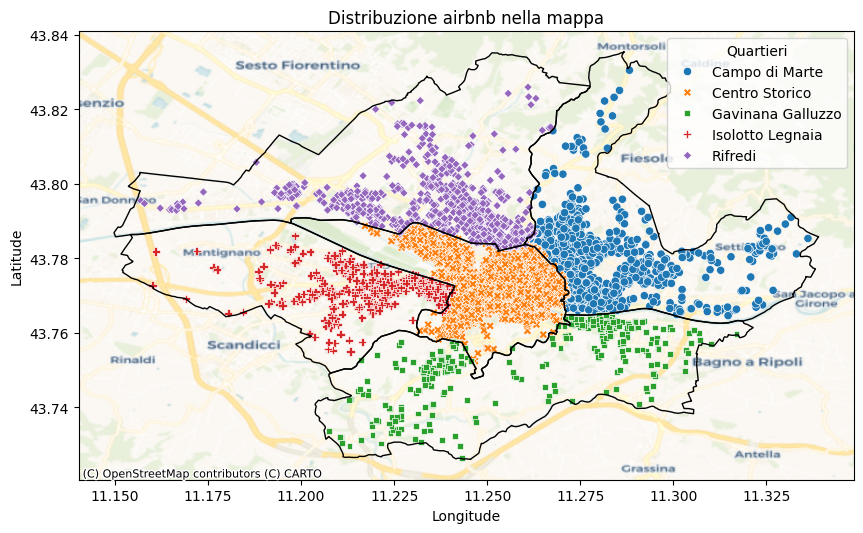

Il numero totale di aibnb è di  10743


In [2]:
df_florence=df_florence.sort_values('neighbourhood_cleansed')
gdf = gpd.GeoDataFrame(df_florence, geometry=gpd.points_from_xy(df_florence.longitude, df_florence.latitude))
gdf.set_crs(epsg=4326, inplace=True)
quartieri_df.set_crs(epsg=4326, inplace=True)
quartieri_df.sort_values(by='neighbourhood',inplace=True)
ax=quartieri_df.plot(figsize=(10,10),color="none",edgecolor='black',zorder=2)
sns.scatterplot(x='longitude',y='latitude',data=df_florence,hue='neighbourhood_cleansed',style='neighbourhood_cleansed',color=sns.color_palette('deep'))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.title('Distribuzione airbnb nella mappa')
plt.legend(title='Quartieri')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print("Il numero totale di aibnb è di ", len(df_florence))

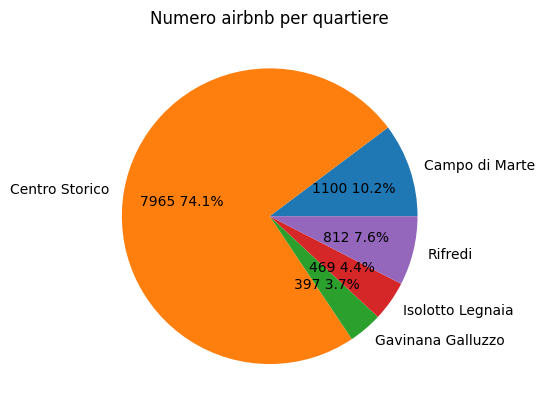

In [3]:
counts = df_florence['neighbourhood_cleansed'].value_counts()
sorted_labels = sorted(counts.index)
sorted_counts = counts.loc[sorted_labels]
plt.title("Numero airbnb per quartiere")
plt.pie(sorted_counts, labels=sorted_labels, autopct=lambda x: calc_n_perc(x,sorted_counts))
plt.show()


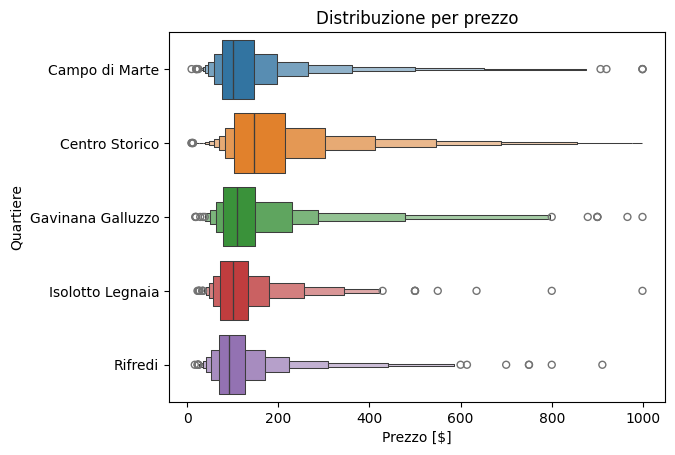

In [4]:
sns.boxenplot(y='neighbourhood_cleansed',x='price',data=df_florence,hue='neighbourhood_cleansed',legend=False)
plt.title('Distribuzione per prezzo')
plt.ylabel('Quartiere')
plt.xlabel('Prezzo [$]')
plt.show()

In [74]:
min_price_df=df_florence['price'].min()
max_price_df=df_florence['price'].max()
title="Mappa dei prezzi per quartiere"
app = dash.Dash(__name__,external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = getContainer(title)

@app.callback(
    Output('map-graph', 'figure'),
    [Input('price-slider', 'value')]
)
def update_map_room_type(price_range):
    min_price, max_price = price_range

    fig = go.Figure()

    quartieri_geojson = quartieri_df.__geo_interface__
    fig.add_trace(go.Choroplethmapbox(
        geojson=quartieri_geojson,
        featureidkey="properties.neighbourhood",
        locations=quartieri_df['neighbourhood'],
        z=[0] * len(quartieri_df),
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],
        marker=dict(line=dict(width=1, color='black')),
        showscale=False,
        hoverinfo='skip'
    ))

    df_filtered = df_florence[(df_florence['price'] >= min_price) & (df_florence['price'] <= max_price)]
    df_filtered = df_filtered.sort_values(by='price')

    for neighbourhood in df_filtered['neighbourhood_cleansed'].unique():
        df_neighbourhood_filtered = df_filtered[df_filtered['neighbourhood_cleansed'] == neighbourhood]
        fig.add_trace(go.Scattermapbox(
            lon=df_neighbourhood_filtered['longitude'],
            lat=df_neighbourhood_filtered['latitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=6,
                color=df_neighbourhood_filtered['price'],
                colorscale='Spectral_r',
                cmin=10,
                cmax=999,
                showscale=False,
            ),
            hovertext=df_neighbourhood_filtered.apply(lambda row: f"Quartiere: {neighbourhood}<br>Prezzo: ${row['price']}", axis=1),
            hoverinfo='text',
            name=neighbourhood,
            legendgroup=neighbourhood,
            showlegend=False,
        ))
        getLegend(fig, neighbourhood)

    getBarColor(fig)
    getUpdate(fig)
    return fig
if __name__ == '__main__':
    app.run_server(debug=False,port=8051)


# Distribuzione dei prezzi in base al tipo di camera

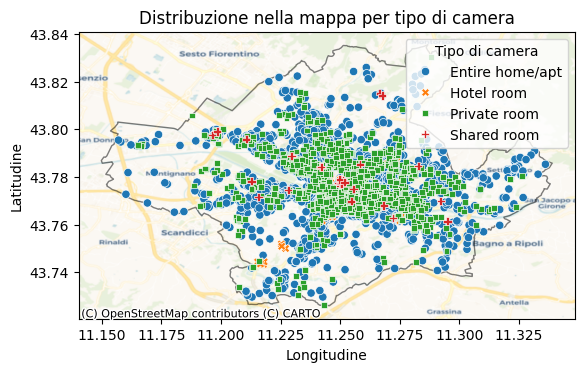

In [6]:
fig,ax=plt.subplots()
quartieri_df_noBorder=quartieri_df.dissolve()
quartieri_df_noBorder.plot(ax=ax,color="none",edgecolor='black',linewidth=1,alpha=0.5)
df_florence=df_florence.sort_values(by='room_type')
sns.scatterplot(ax=ax,data=df_florence,x='longitude',y='latitude',hue='room_type',style='room_type',legend=True)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

plt.title('Distribuzione nella mappa per tipo di camera')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.legend(title='Tipo di camera')
plt.show()

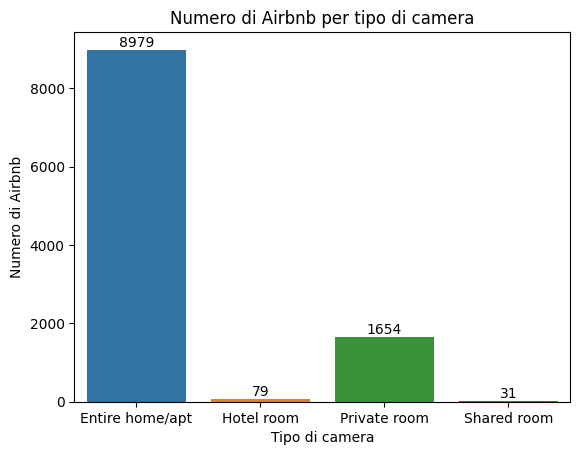

In [7]:
bar_plot=sns.countplot(data=df_florence,x='room_type',hue='room_type')
for label in bar_plot.containers:
    bar_plot.bar_label(label)
plt.title("Numero di Airbnb per tipo di camera")
plt.xlabel('Tipo di camera')
plt.ylabel('Numero di Airbnb')
plt.show()

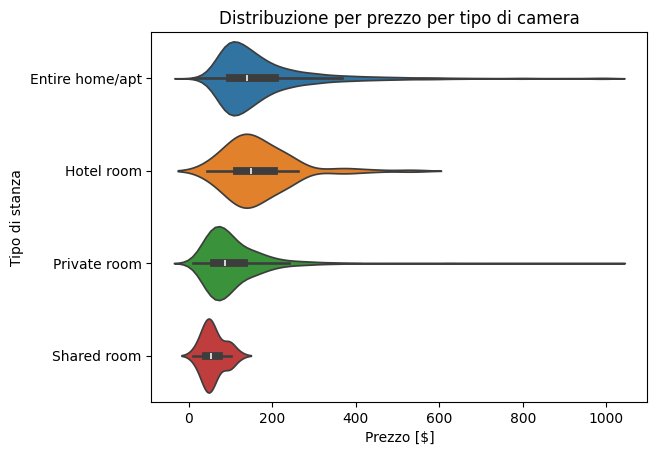

In [8]:
sns.violinplot(data=df_florence,x='price',y='room_type',hue='room_type')
plt.title('Distribuzione per prezzo per tipo di camera')
plt.xlabel('Prezzo [$]')
plt.ylabel('Tipo di stanza')
plt.show()

In [66]:
app = dash.Dash(__name__,external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = getContainer("Mappa dei prezzi per tipi di camera")
@app.callback(
    Output('map-graph', 'figure'),
    [Input('price-slider', 'value')]
)
def update_map_room_type(price_range):
    min_price, max_price = price_range
    fig2 = go.Figure()
    quartieri_geojson = quartieri_df_noBorder.__geo_interface__
    fig2.add_trace(go.Choroplethmapbox(
        geojson=quartieri_geojson,
        featureidkey="properties.neighbourhood",
        locations=[feature['properties']['neighbourhood'] for feature in quartieri_geojson['features']],
        z=[0] * len(quartieri_df),  
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  
        marker=dict(line=dict(width=1, color='black')),
        showscale=False,
        hoverinfo='skip'
    ))
    df_filtered = df_florence[(df_florence['price'] >= min_price) & (df_florence['price'] <= max_price)]
    df_filtered = df_filtered.sort_values(by='price')
    for room_type in df_filtered['room_type'].unique():
        df_type_filtered = df_filtered[df_filtered['room_type'] == room_type]
        fig2.add_trace(go.Scattermapbox(
            lon=df_type_filtered['longitude'],
            lat=df_type_filtered['latitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=6,
                color=df_type_filtered['price'],
                colorscale='Spectral_r',
                cmin=min_price_df,
                cmax=max_price_df,
                showscale=False,
            ),
            hovertext=df_type_filtered.apply(lambda row: f"Tipo di camera: {room_type}<br>Prezzo: ${row['price']}", axis=1),
            hoverinfo='text',
            name=room_type,
            legendgroup=room_type,
            showlegend=False,
        ))
        getLegend(fig2,room_type)
    getBarColor(fig2)
    getUpdate(fig2)
    pio.write_html(fig2, 'mappa2.html')
    return fig2
if __name__ == '__main__':
    app.run_server(debug=False,port=8050)


# Per rispondere alla seconda domanda
## Che Airbnb cercavo:
- Airbnb per due ospiti
- Airbnb per due notti
- Airbnb in zona centrale della città
- Airbnb con camera privata
- Airbnb con aria condizionata

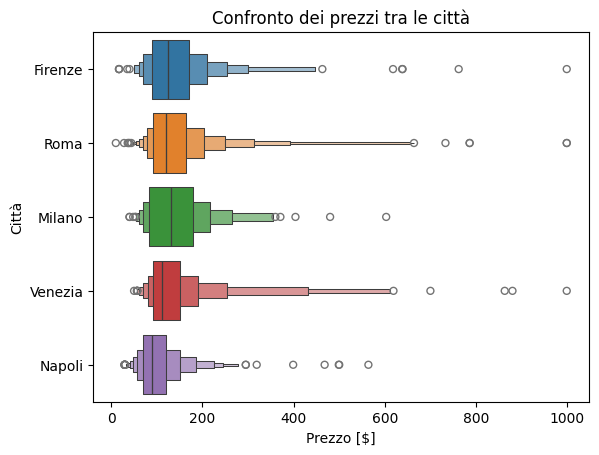

In [49]:
df_rome=create_dataframe(pd.read_csv('Roma/listings.csv'))
df_milan=create_dataframe(pd.read_csv('Milano/listings.csv'))
df_venice=create_dataframe(pd.read_csv('Venezia/listings.csv'))
df_naples=create_dataframe(pd.read_csv('Napoli/listings.csv'))
df=set_dataframe(df_florence)

quartieri_napoli=np.array(["Avvocata", "Montecalvario", "San Giuseppe", "Porto", "Pendino", "Mercato", "Chiaia", "San Ferdinando", "Stella", "San Carlo all'Arena", "San Lorenzo","Vicaria"],dtype=str)
quartieri_milano=np.array(["DUOMO", "BRERA", "GIARDINI PORTA VENEZIA", "GUASTALLA", "MAGENTA - S. VITTORE", "PARCO SEMPIONE", "VIGENTINA", "TICINESE", "PAGANO", "SARPI"],dtype=str)

df=df[df['neighbourhood_cleansed']=='Centro Storico']
df_rome=df_rome[df_rome['neighbourhood_cleansed']=='I Centro Storico']
df_venice=df_venice[df_venice['neighbourhood_group_cleansed']=='Isole']
df_naples=df_naples[df_naples['neighbourhood_cleansed'].isin(quartieri_napoli)]
df_milan=df_milan[df_milan['neighbourhood_cleansed'].isin(quartieri_milano)]

df['city']='Firenze'
df_rome['city']='Roma'
df_venice['city']='Venezia'
df_milan['city']='Milano'
df_naples['city']='Napoli'

df_all = pd.concat([df,df_rome, df_milan, df_venice, df_naples])
sns.boxenplot(y='city', x='price', data=df_all,hue='city')
plt.title('Confronto dei prezzi tra le città')
plt.ylabel('Città')
plt.xlabel('Prezzo [$]')
plt.show()


# Conclusioni

### Distribuzione dei prezzi in base alla tipologia di camera e al quartiere

| Tipo di Camera | Mediana Prezzo [$] |
|----------------|---------------------|
| Hotel room         | 149.0                  |
| Entire home/apt          | 140.0                  |
| Private room           | 86.0                 |
| Shared room           | 53.0                 |


| Tipo di Camera | Mediana Prezzo [$] |
|----------------|---------------------|
| Centro Storico         | 146.0                  |
| Gavinana Galluzzo          | 140.0                  |
| Campo di Marte           | 100.0                 |
| Isolotto Legnaia           | 100.0                 |
| Rifredi           | 93.0                 |




### Classifica delle città più costose

| Città              | Prezzo medio [$] |
| :---------------- | ------:  |
| Milano        |   130.00    |
| Firenze         |   125.00    |
| Roma    |  120.00    |
| Venezia |  112.00   |
| Napoli |  89.00   |